In [ ]:
@dataclass
class Config:
    device: int = 0
    # data args
    data_path: str = "/scratch/network/mk8574/audio_sentiment_challenge/data"
    val_size: float = 0.2
    
    train_transforms: audiomentations.OneOf([
        audiomentations.AddGaussianNoise(p=0)
    ]) = None
    # [
    #     audiomentations.AddGaussianNoise(p=0.75),
    #     audiomentations.PitchShift(p=0.75),
    #     audiomentations.PeakingFilter(p=0.75),
    #     audiomentations.SevenBandParametricEQ(p=0.75),
    #     audiomentations.BandPassFilter(p=0.75),
    #     audiomentations.BandStopFilter(p=0.75),
    #     audiomentations.AirAbsorption(p=0.75),
    #     audiomentations.ClippingDistortion(p=0.75),
    #     audiomentations.HighPassFilter(p=0.75),
    #     audiomentations.HighShelfFilter(p=0.75),
    #     audiomentations.Limiter(p=0.75),
    #     audiomentations.LowPassFilter(p=0.75),
    #     audiomentations.LowShelfFilter(p=0.75),
    # ]) = None

    # save dir
    train_serial = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir: str = f"/scratch/network/mk8574/audio_sentiment_challenge/baseline_dy/results/{train_serial}"

    # model args
    pretrained_name: str = "ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition"

    # hparams
    seed: int = 42
    max_epoch: int = 32
    lr: float = 5e-4
    batch_size: int = 32
    total_batch_size: int = 32
    gradient_accumulate_step: int = 1  # total batch size = batch_size * gradient_accumulate_step
    early_stop_patience = 5
    
config = Config()

device = torch.device(f'cuda:{config.device}') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed) # Seed 고정


train_df = pd.read_csv(os.path.join(config.data_path, 'train.csv'))
train_df, valid_df = train_test_split(train_df, test_size=config.val_size, random_state=config.seed)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

class MyDataSet(Dataset):
    def __init__(self, df, feature_extractor, mode='train', transforms=None):
        self.df = df
        self.feature_extractor = feature_extractor
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(config.data_path, self.df['path'][idx][2:])
        
        waveform, sample_rate = librosa.load(path)
        sr = self.feature_extractor.sampling_rate
        waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=sr)
        
        if self.transforms is not None:
            waveform = self.transforms(samples=np.array(waveform, dtype=np.float32), sample_rate=sr)
        
        input_values = self.feature_extractor(waveform, sampling_rate=sr, return_tensors="pt", padding=True).input_values
        
        if self.mode!= 'test':
            label = self.df['label'][idx]
            return input_values.squeeze(), label
        else:
            return input_values.squeeze()

        
def collate_fn_yes_label(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence([torch.tensor(wave) for wave in waveforms], batch_first=True)
    labels = torch.tensor(labels)
    return waveforms, labels

def collate_fn_no_label(batch):
    waveforms = zip(*batch)
    waveforms = pad_sequence([torch.tensor(wave) for wave in waveforms], batch_first=True)
    return waveforms



feature_extractor = AutoFeatureExtractor.from_pretrained(config.pretrained_name)

train_dataset = MyDataSet(train_df, feature_extractor, mode='train', transforms=config.train_transforms)
valid_dataset = MyDataSet(valid_df, feature_extractor, mode='val')

train_loader = DataLoader(train_dataset,
                          batch_size=config.batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_yes_label,
                          num_workers=16)
valid_loader = DataLoader(valid_dataset,
                          batch_size=config.batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_yes_label,
                          num_workers=16)


class MyModel(torch.nn.Module):
    def __init__(self, pretrained_name: str):
        super(MyModel, self).__init__()
        self.model = AutoModelForAudioClassification.from_pretrained(pretrained_name)
        
        self.model.classifier = nn.Linear(in_features=self.model.projector.out_features, out_features=6)
        nn.init.kaiming_normal_(self.model.classifier.weight, mode="fan_in", nonlinearity="relu")
        nn.init.zeros_(self.model.classifier.bias)

    def forward(self, x):
        output = self.model(x)
        return output.logits
    
def validation(model, valid_loader, creterion):
    model.eval()
    val_loss = []

    total, correct = 0, 0

    with torch.no_grad():
        for waveforms, labels in tqdm(iter(valid_loader)):
            waveforms = waveforms.to(device)
            labels = labels.to(device)

            output = model(waveforms)            
            loss = creterion(output, labels)

            val_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).cpu().sum()

    accuracy = correct / total

    avg_loss = np.mean(val_loss)

    return avg_loss, accuracy



def train(model, train_loader, valid_loader, optimizer, scheduler, mode = 'none'):
    accumulation_step = int(config.total_batch_size / config.batch_size)
    model.to(device)
    creterion = nn.CrossEntropyLoss(label_smoothing = 0.0).to(device)
    #creterion = nn.CrossEntropyLoss(label_smoothing = 0.0).to(device)
    best_model = None
    best_acc = 0

    for epoch in range(1, config.max_epoch+1):
        train_loss = []
        model.train()
        
        for i, (waveforms, labels) in enumerate(tqdm(train_loader)):
            waveforms = waveforms.to(device)
            labels = labels.flatten().to(device)

            optimizer.zero_grad()
            
            output = model(waveforms)
            loss = creterion(output, labels)
            loss.backward()

            if (i+1) % accumulation_step == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss.append(loss.item())

        avg_loss = np.mean(train_loss)
        valid_loss, valid_acc = validation(model, valid_loader, creterion)
        
        return model, train_loader, valid_loader
        
        if scheduler is not None:
            scheduler.step(valid_loss)

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model

        print(f'epoch:[{epoch}] train loss:[{avg_loss:.5f}] valid_loss:[{valid_loss:.5f}] valid_acc:[{valid_acc:.5f}]')
    
    print(f'best_acc:{best_acc:.5f}')

    return best_model

model = MyModel(config.pretrained_name)

optimizer = torch.optim.AdamW(
    [{"params": module.parameters(), "lr": config.lr if name == "classifier" else config.lr * 0.1} for name, module in model.named_children()],
    weight_decay=0.1,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


best_model = train(model, train_loader, valid_loader, optimizer, scheduler)

test_df = pd.read_csv(os.path.join(config.data_path, 'test.csv'))
test_df.reset_index(drop=True, inplace=True)

test_dataset = MyDataSet(test_df, feature_extractor, mode='test')

test_loader = DataLoader(test_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        collate_fn=collate_fn_no_label,
                        num_workers=16)

def inference(model, test_loader):
    model.eval()
    preds = []

    with torch.no_grad():
        for x in tqdm(iter(test_loader)):
            x = x.to(device)

            output = model(x)

            preds += output.argmax(-1).detach().cpu().numpy().tolist()

    return preds

preds = []

for (waveforms, labels) in tqdm((train_loader)):
    waveforms = waveforms.to(device)
    
    output = best_model[0](waveforms)
    preds += output.argmax(-1).detach().cpu().numpy().tolist()
    
preds.to_csv('preds.csv')
# preds = inference(best_model, test_loader)

# submission = pd.read_csv(os.path.join(config.data_path, 'sample_submission.csv'))
# submission['label'] = preds
# submission.to_csv(os.path.join(config.save_dir, 'submission.csv'), index=False)

/home/mk8574/.conda/envs/mk8574_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'classifier.output.weight', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.output.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-e

In [2]:
import os
import json
import random
import warnings
from datetime import datetime
from dataclasses import asdict, dataclass
from sklearn.model_selection import train_test_split

import librosa
import audiomentations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModelForAudioClassification, AutoFeatureExtractor

warnings.filterwarnings(action='ignore')

/home/mk8574/.conda/envs/mk8574_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
best_model[1]

In [ ]:
preds = []

for (waveforms, labels) in tqdm((train_loader)):
    waveforms = waveforms.to(device)
    
    output = best_model[0](waveforms)
    preds += output.argmax(-1).detach().cpu().numpy().tolist()

In [ ]:
def mean_avg(PATH):
    # path = '../data/train/TRAIN_4677.wav' 
    # os.path.join(config.data_path, self.df['path'][idx][2:])
    waveform, sample_rate = librosa.load(PATH)
    waveform = waveform ** 2

    mean_avg = sum(waveform)/len(waveform)
    
    return mean_avg

In [ ]:
train_df['label'].value_counts()

In [ ]:
import matplotlib.pyplot as plt

lst = []
for i in range(6):
    lst.append([])
    for PATH in train_df[train_df['label'] == i]['path']:
        lst[i].append(mean_avg(os.path.join('../data', PATH)))

In [ ]:
import statistics 

for i in range(6):
    plt.hist(lst[i], label = i, bins = np.arange(0, 0.02, 0.0003))
    
    print(f"{i} class: mean {sum(lst[i])/len(lst[i]) * 1000} std {statistics.pstdev(lst[i]) * 1000}")
#     plt.show()

plt.legend()
plt.show()

In [3]:
from xgboost import XGBClassifier

xg_clf = XGBClassifier(n_estmiators = 2, max_depth = 3, learning_rate = 1)

5001
label: 2
Wav length: 2.2689375, Mel_S shape:(40, 227)
fft shape:  (36303,)


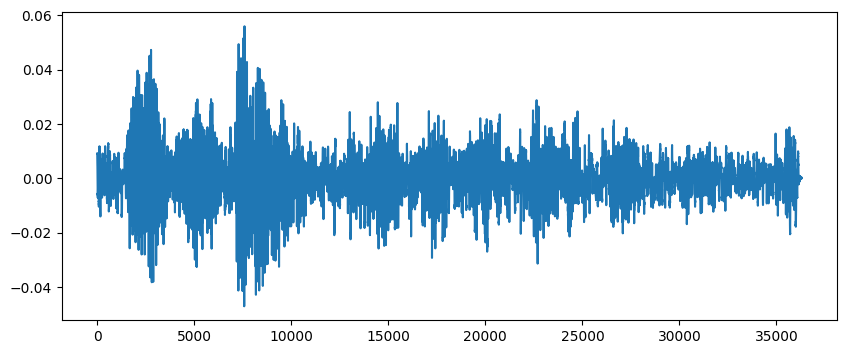

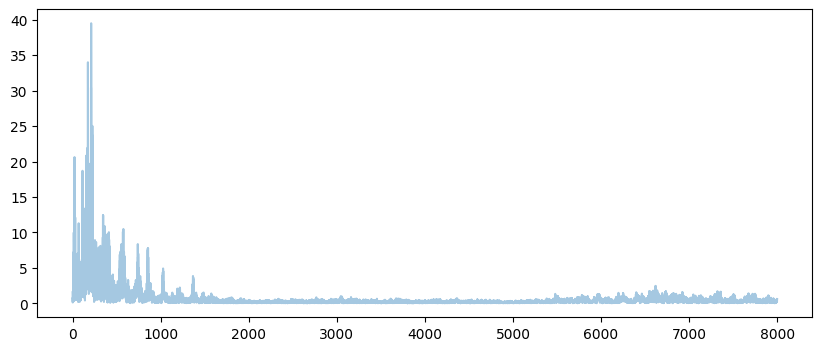

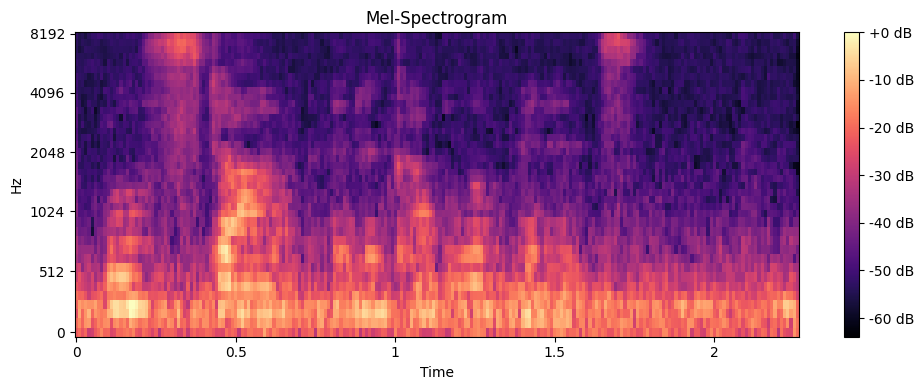

label: 4
Wav length: 2.7026875, Mel_S shape:(40, 271)
fft shape:  (43243,)


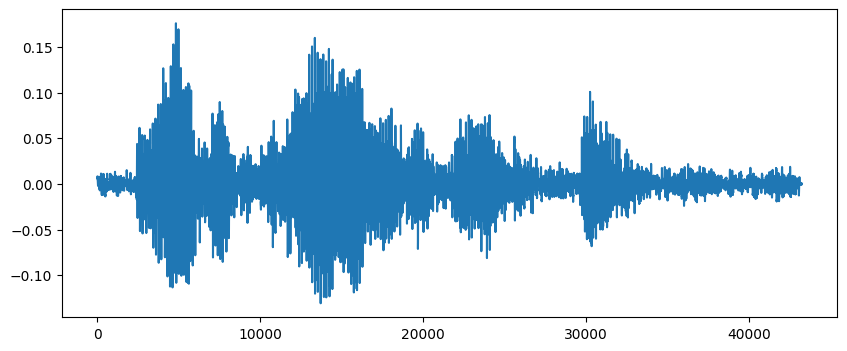

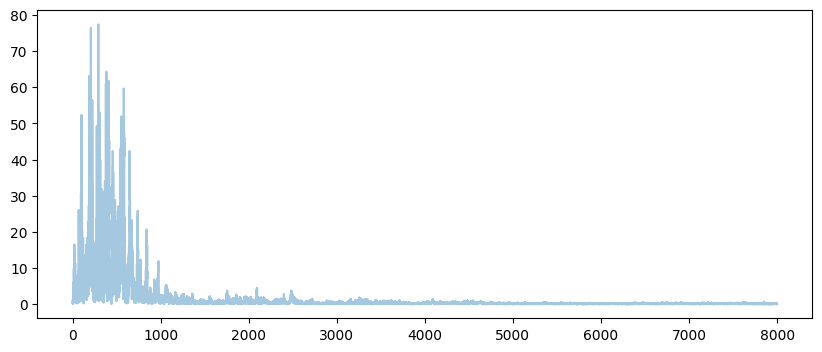

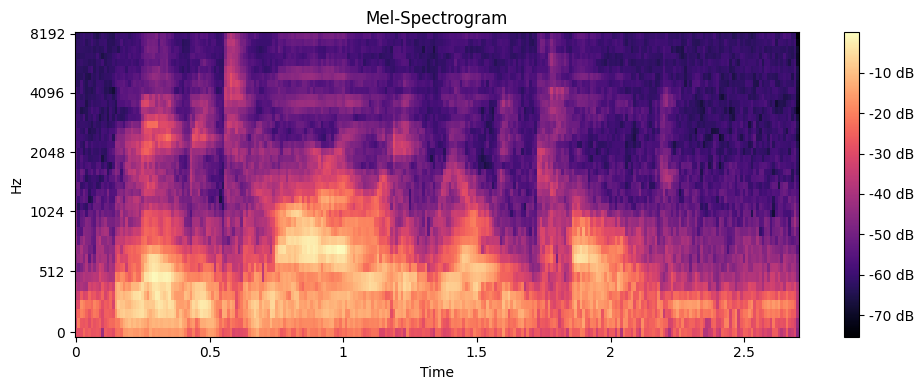

label: 5
Wav length: 1.56825, Mel_S shape:(40, 157)
fft shape:  (25092,)


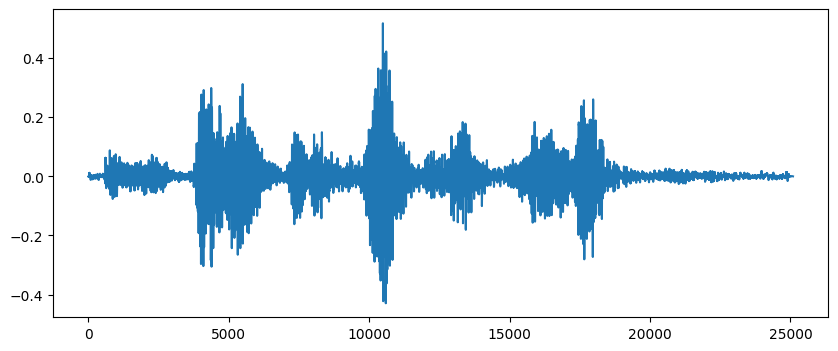

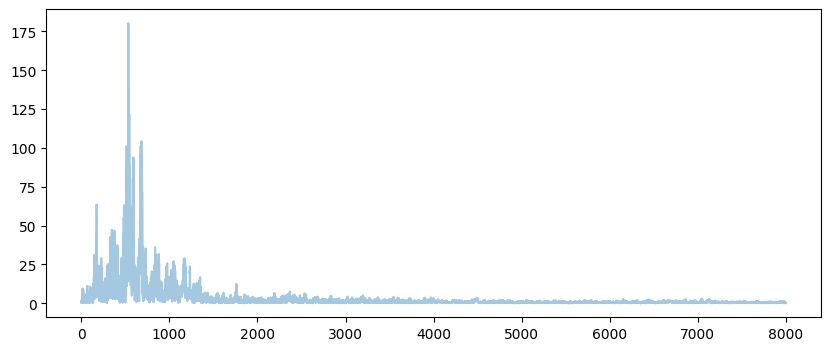

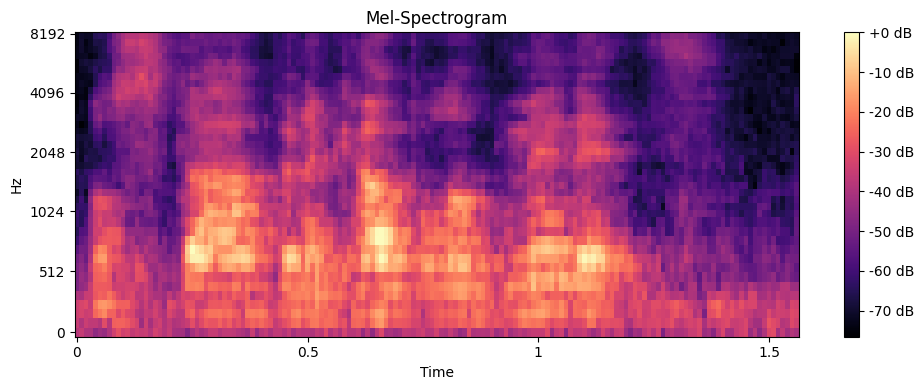

label: 0
Wav length: 2.3023125, Mel_S shape:(40, 231)
fft shape:  (36837,)


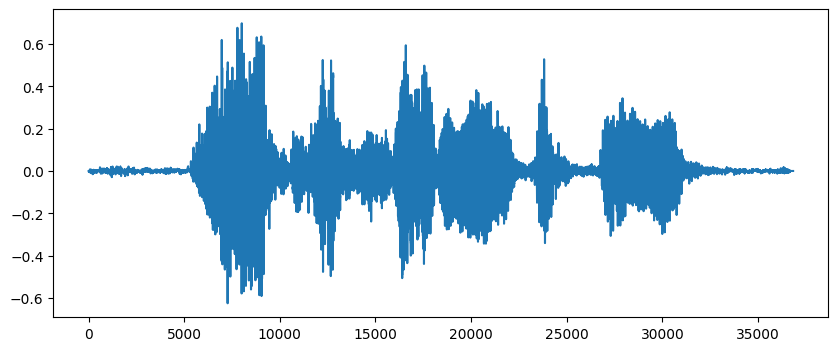

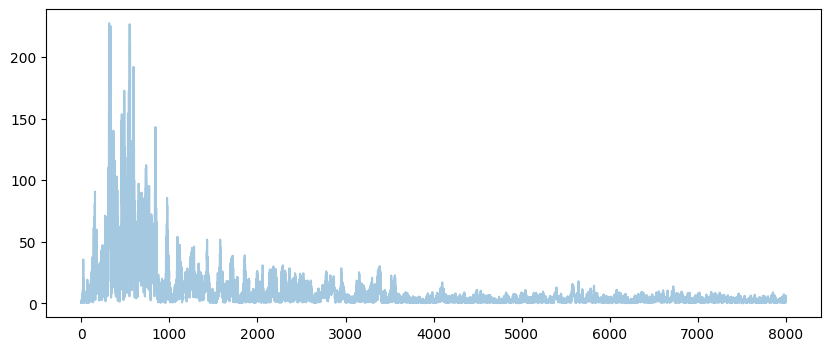

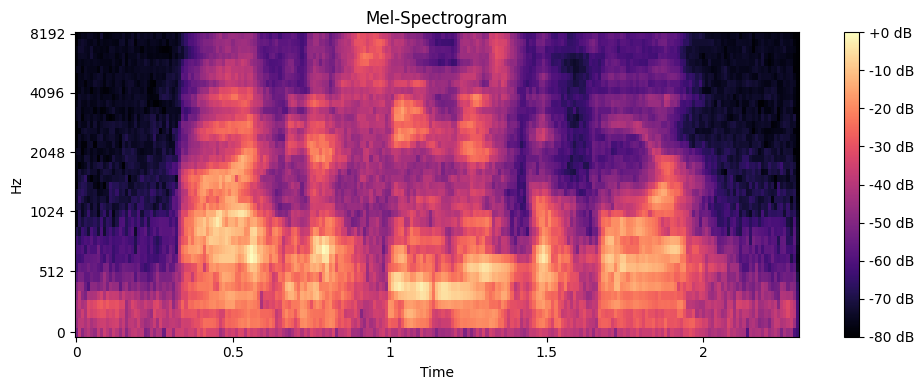

label: 5
Wav length: 2.969625, Mel_S shape:(40, 297)
fft shape:  (47514,)


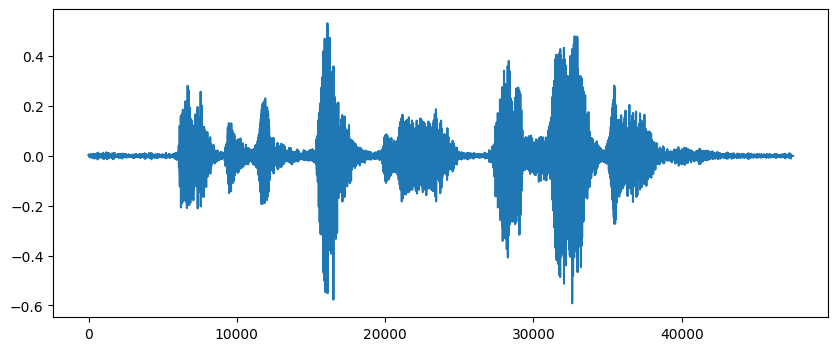

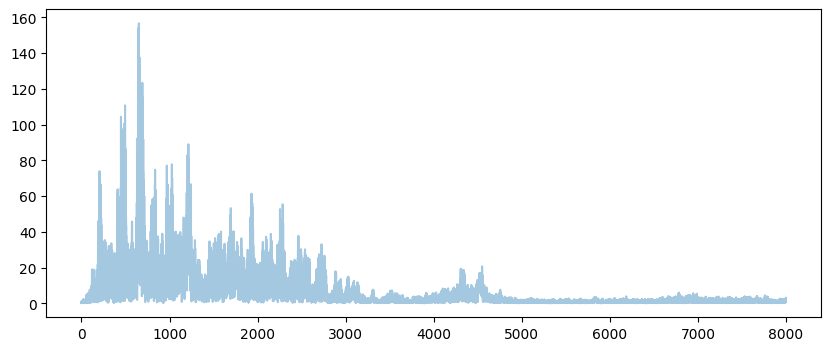

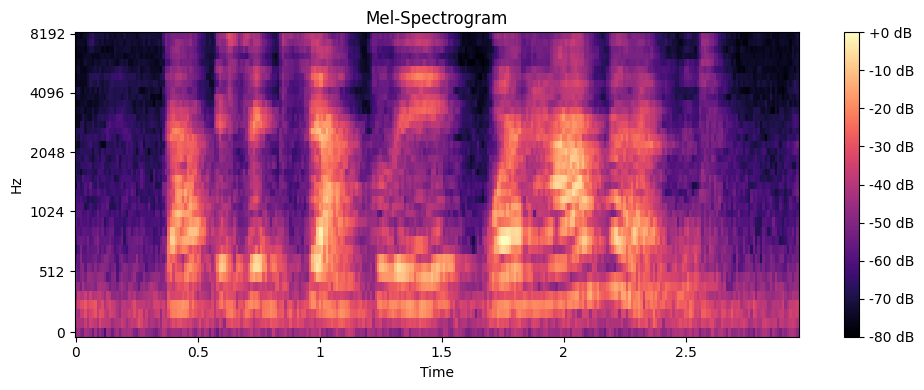

label: 1
Wav length: 2.5025, Mel_S shape:(40, 251)
fft shape:  (40040,)


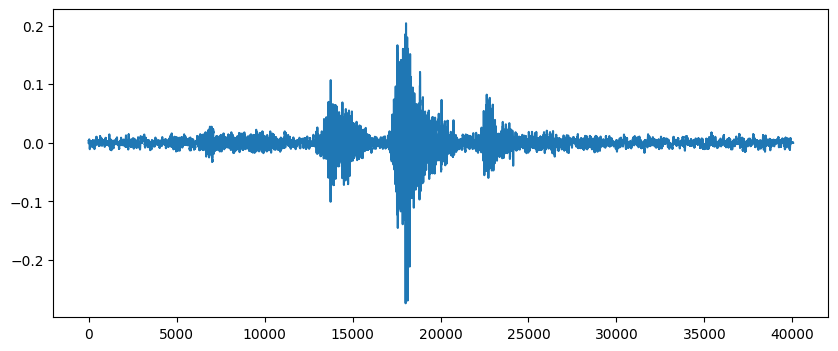

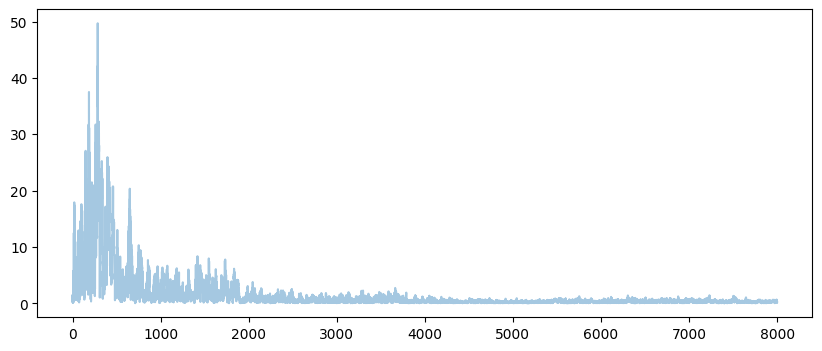

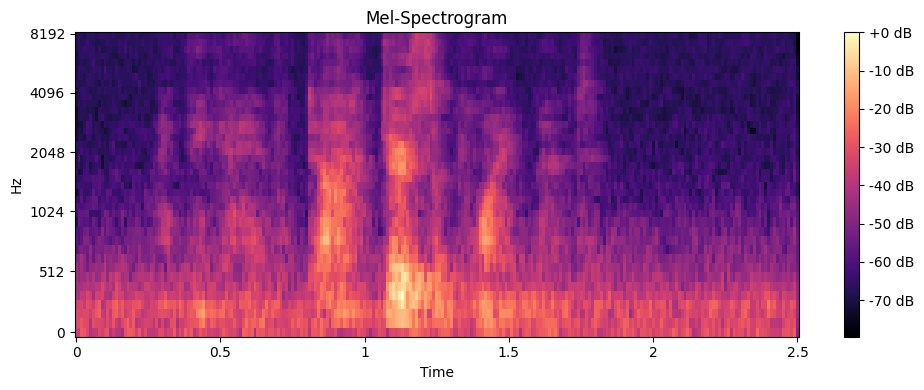

label: 2
Wav length: 2.035375, Mel_S shape:(40, 204)
fft shape:  (32566,)


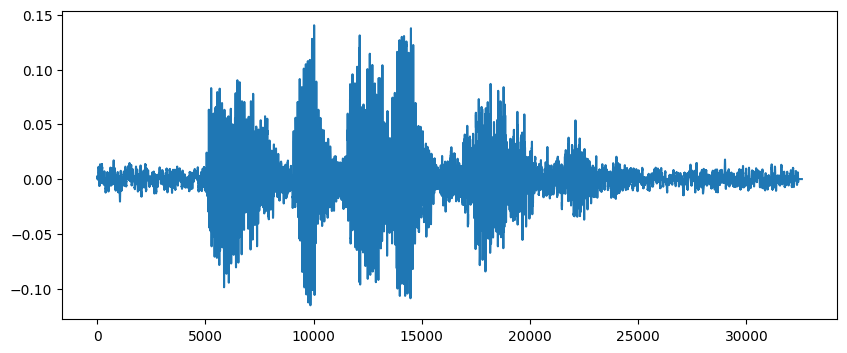

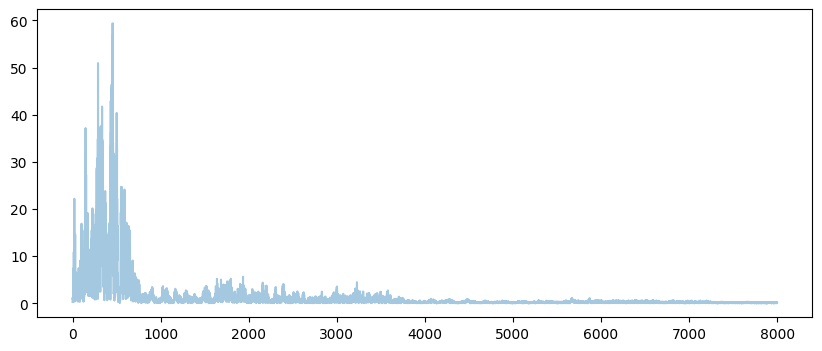

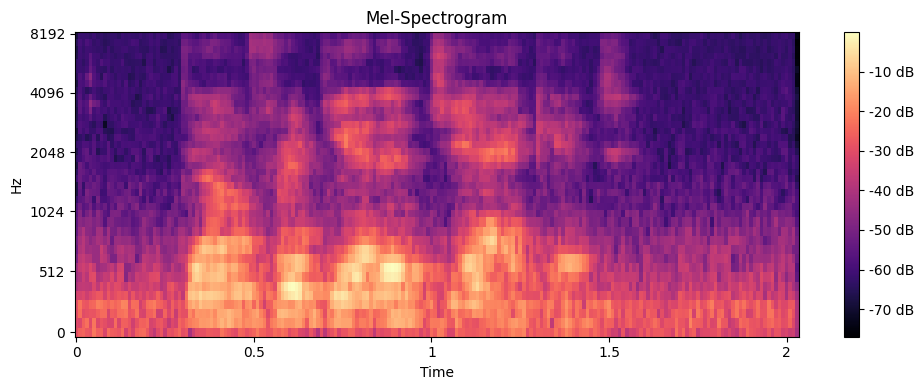

label: 5
Wav length: 2.43575, Mel_S shape:(40, 244)
fft shape:  (38972,)


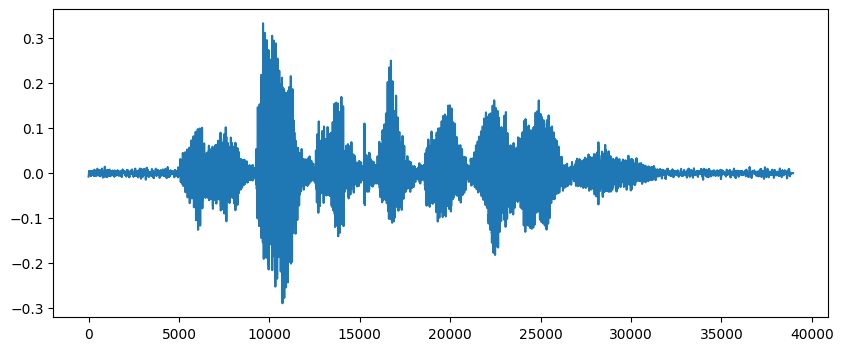

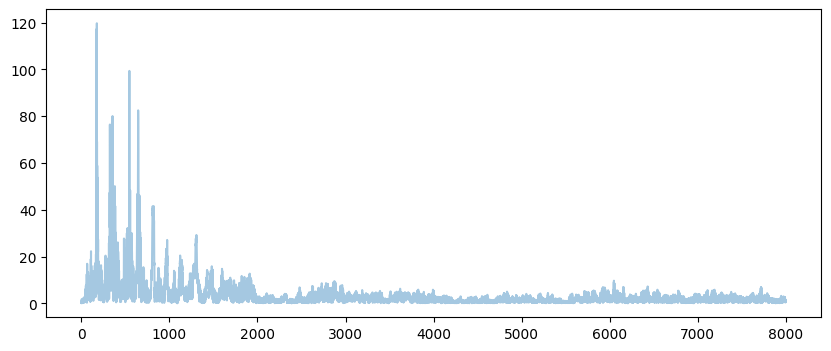

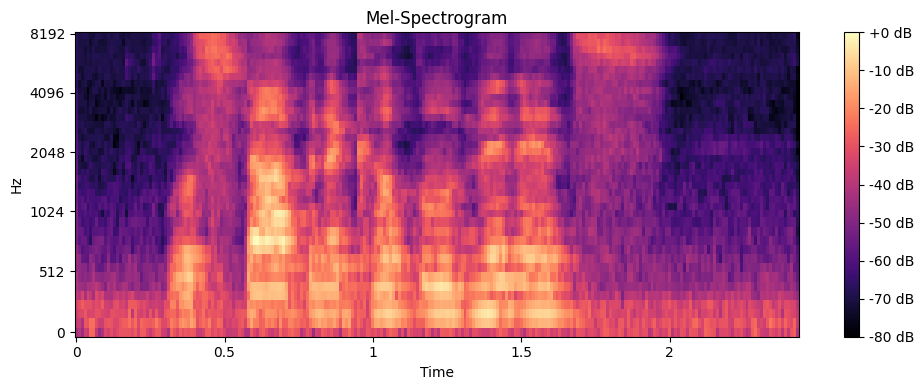

label: 4
Wav length: 3.3033125, Mel_S shape:(40, 331)
fft shape:  (52853,)


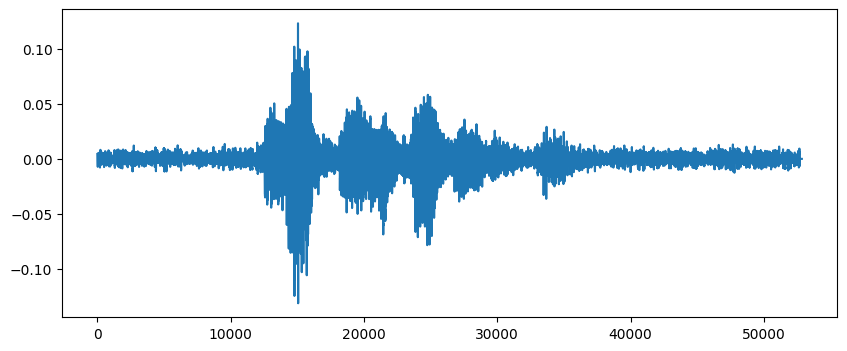

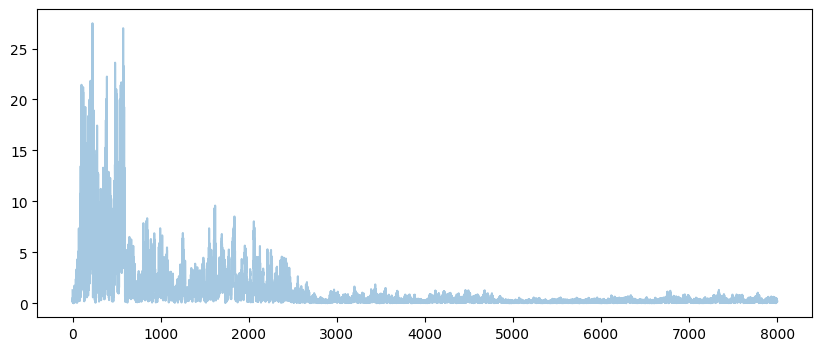

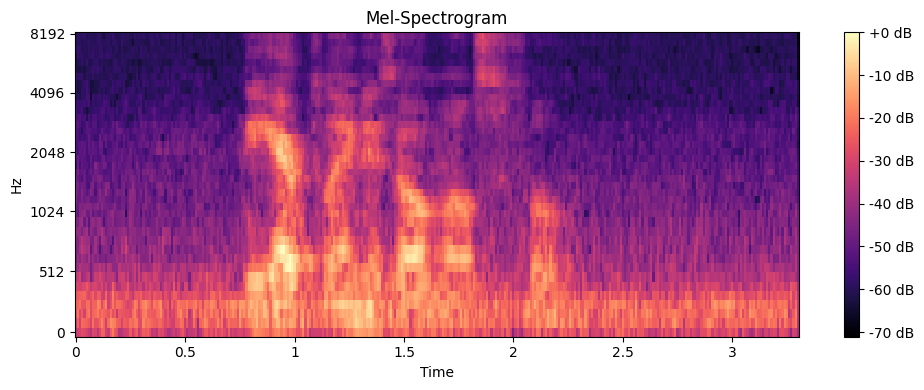

label: 2
Wav length: 2.43575, Mel_S shape:(40, 244)
fft shape:  (38972,)


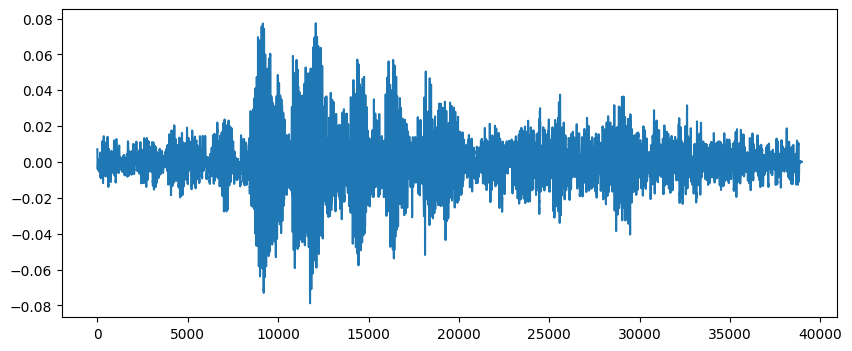

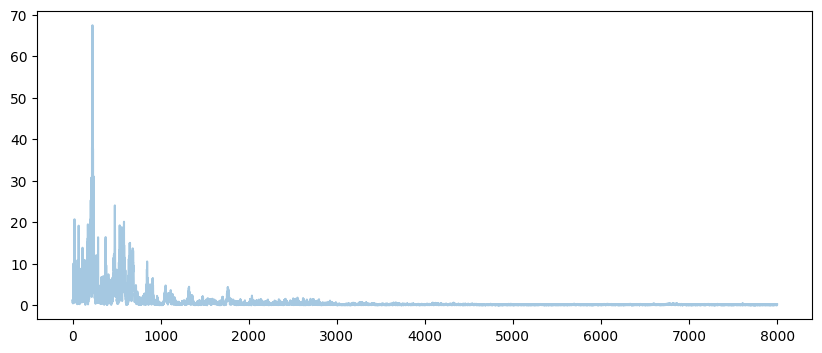

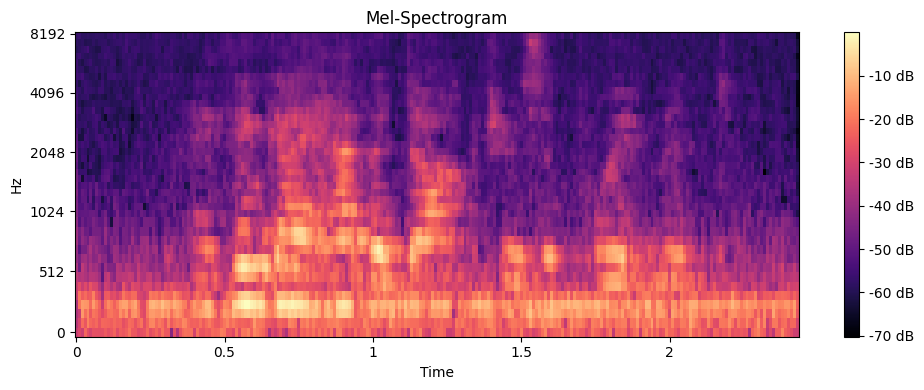

In [13]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random 

frame_length = 0.025
frame_stride = 0.010

def Mel_S(wav_file):
    # mel-spectrogram
    y, sr = librosa.load(wav_file, sr=16000)

    # wav_length = len(y)/sr
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))

    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)

    print("Wav length: {}, Mel_S shape:{}".format(len(y)/sr,np.shape(S)))

    fft = np.fft.fft(y)
    print("fft shape: ", fft.shape)
    
    spectrum = np.abs(fft)
    f = np.linspace(0, sr, len(spectrum))
    
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    
    plt.figure(figsize = (10, 4))
    plt.plot(y)
    
    plt.figure(figsize = (10, 4))
    plt.plot(left_f, left_spectrum, alpha = 0.4)
    
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.savefig('Mel-Spectrogram example.png')
    plt.show()

    return S

df = pd.read_csv('../data/train.csv')
x = print(len(df))
for i in random.sample(range(len(df)), 10):
    man_original_data = os.path.join('../data', df['path'][i])
    print(f"label: {df['label'][i]}")
    mel_spec = Mel_S(man_original_data)